In [7]:
import matplotlib.pyplot as plt
import strauss
from strauss.sonification import Sonification
from strauss.sources import Objects
from strauss.generator import Generator
from strauss import channels
from strauss.generator import Sampler
from strauss.score import Score
from strauss.generator import Synthesizer
import IPython.display as ipd
from strauss.sources import Events
import os
from scipy.interpolate import interp1d
import numpy as np
import copy
import wavio as wav

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
from mike_code import LaguerreAmplitudes
from functionalities import *
import matplotlib.cm as cm
from skimage.transform import resize_local_mean
from combine_sonifications import combine_save_sonifications

import time

from FLEX_ed import ExpandGalaxies, BeefIt
import time
import fluidsynth
import numpy as np
import glob

opening image
Reff =  45.434914524837986  Galaxy Radius:  272.6094871490279
getting pixel info, galaxy radius, mask, etc
finding center of image
center of mass estimate 7.493571088044606 2.8364626248696054
center finding iteration 0
center finding iteration 50
center finding iteration 100
Center of mass at x = 1.1586380803618415, y = 0.45490448299759967
finding best rscl
New rscl value: 33
updating to new_mmax, new_nmax


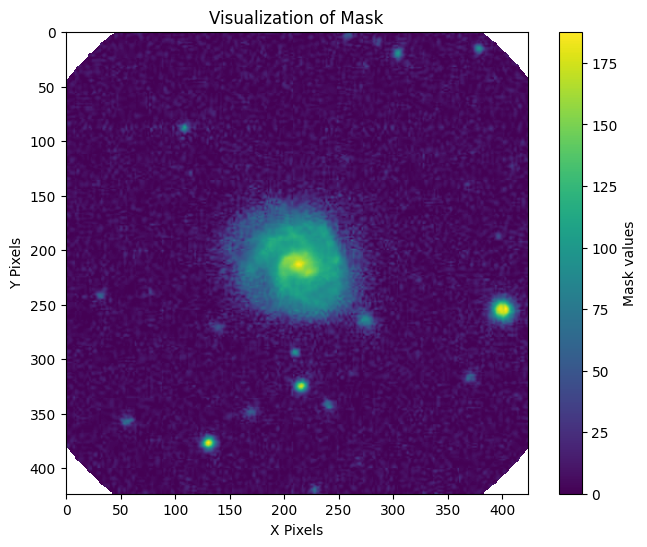

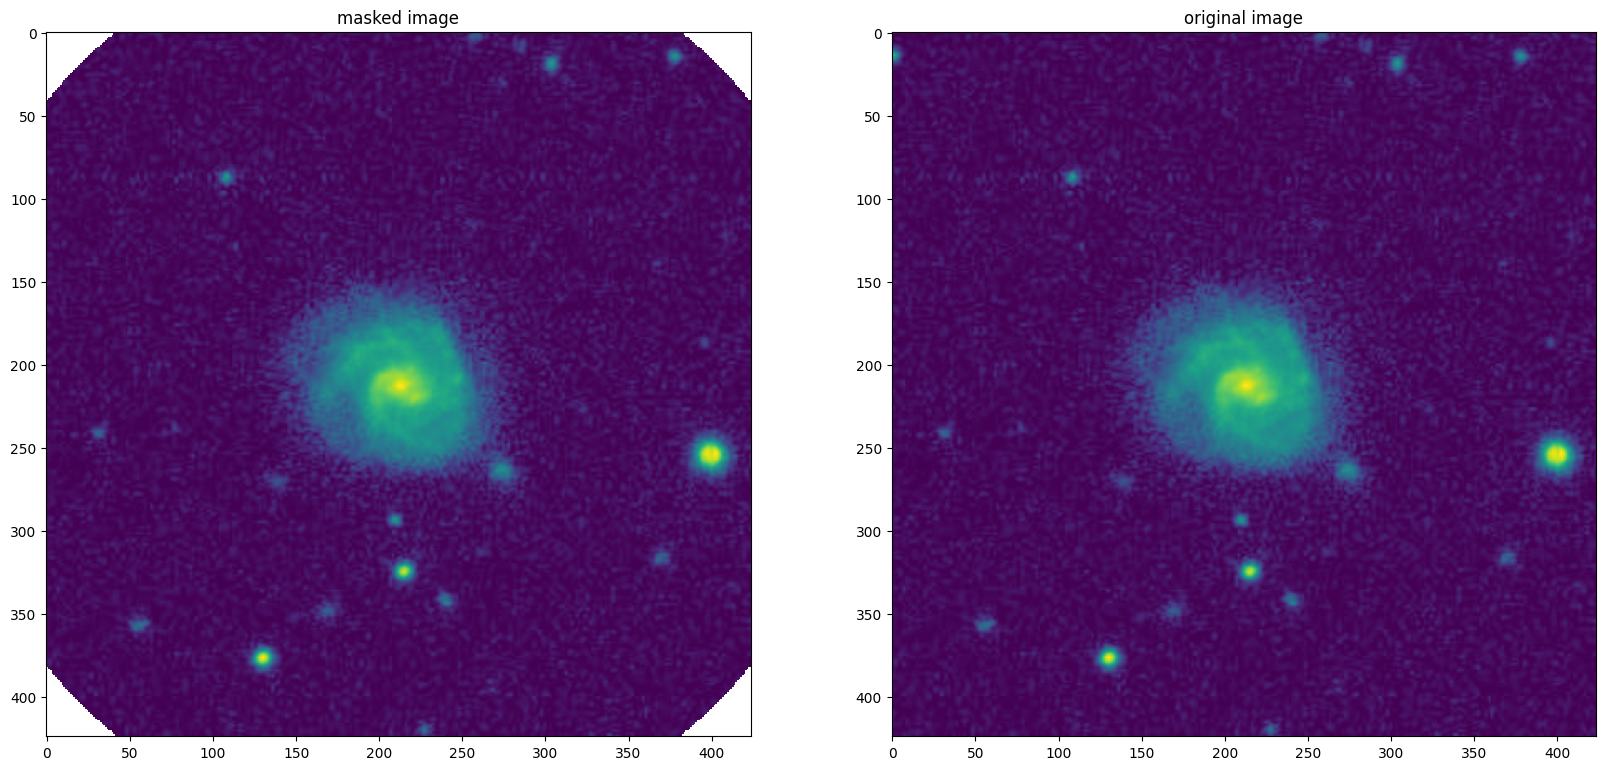

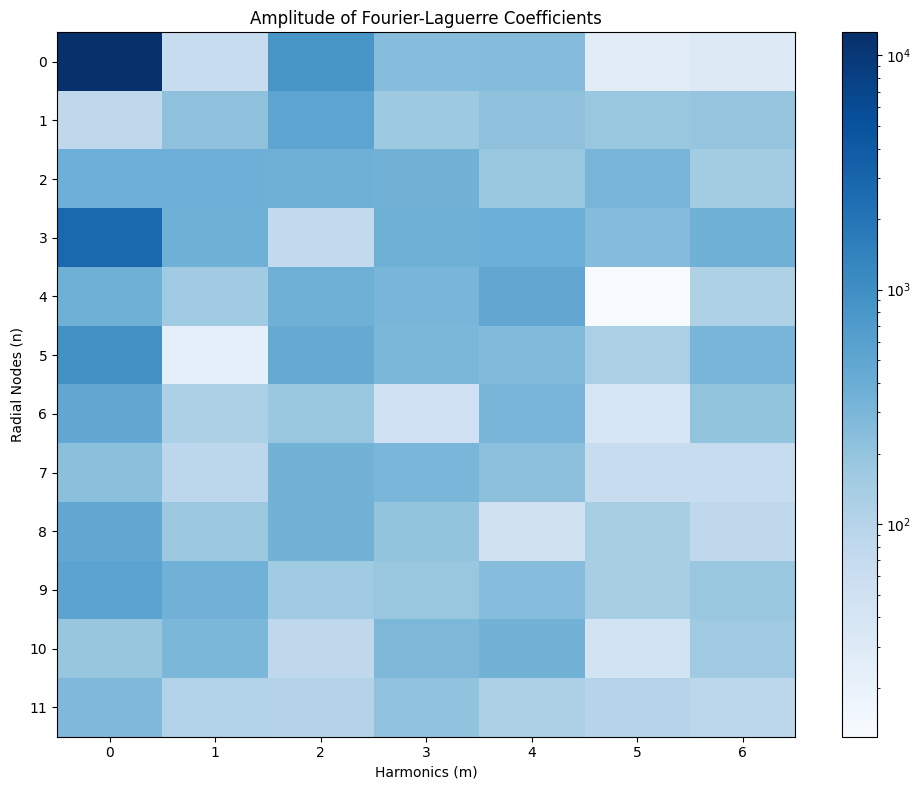

/Users/cfilion/Developer/sonification/FLEX_ed.py:721: RuntimeWarning: divide by zero encountered in divide
  ax3.imshow(((reconstruction - fixed_image) / fixed_image).T,cmap='bwr',vmin=-1,vmax=1)


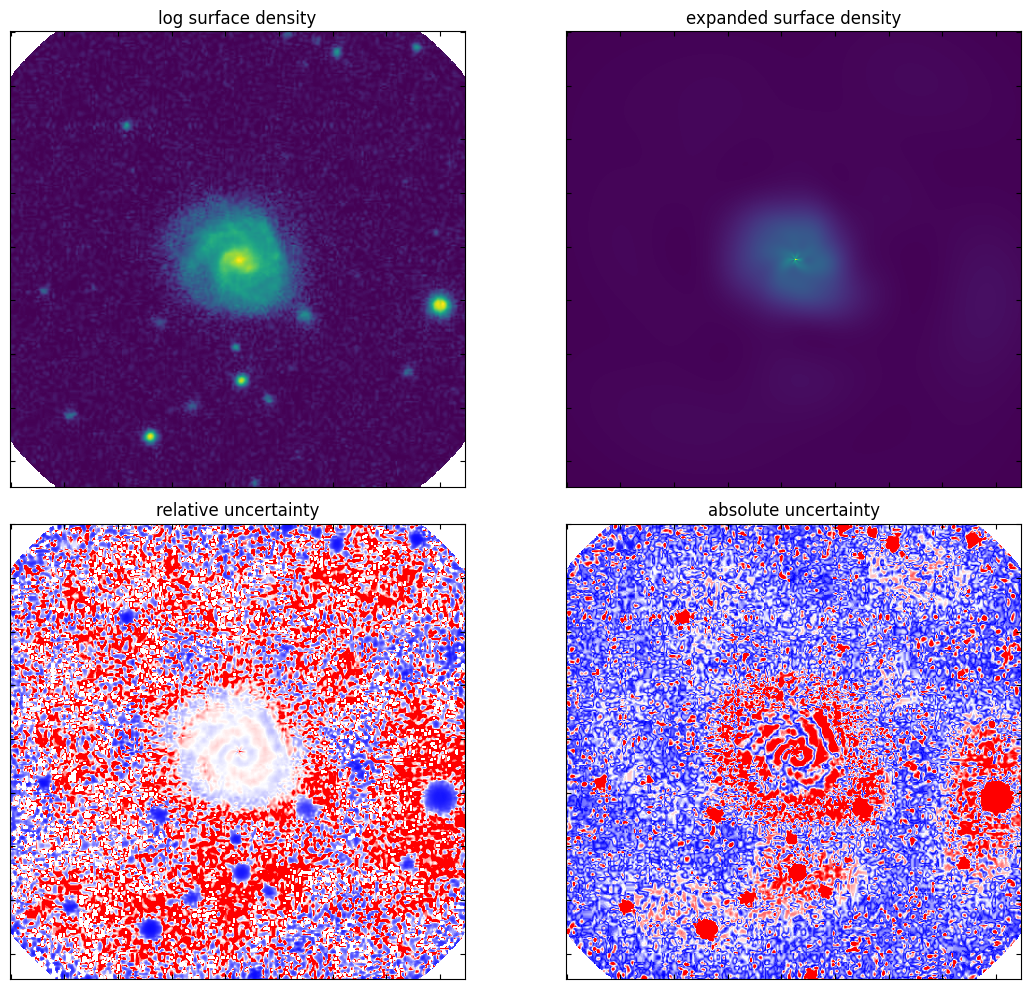

returning cosine coefficients, sine coefficients
it takes  36.97012686729431  to do one expansion


In [6]:
start = time.time()
cos_cos_712, sin_cos_712 = BeefIt('GZ2_images/293157.jpg', rscl_initial = 50, 
                                        mmax_initial = 2, nmax_initial = 10,
                                       new_mmax = 7, new_nmax = 12)
end = time.time()
print('it takes ', end - start, ' to do one expansion')

In [340]:
from mido import Message, MidiFile, MidiTrack
import mido
def mod_map_to_sounds_octave_ampcutoff(cos_cos, sin_cos):
    note_list = np.array(['D#','A#','F','C','G', 'D', 'A', 'E','B','F#','C#','G#'])
    #np.array(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']) 
    mmax = cos_cos.shape[0]
    nmax = cos_cos.shape[1]

    modulus = np.sqrt(cos_cos**2 + sin_cos**2)
    
    abs_max = np.max(modulus)
    note_dict = {}
    
    for m in range(mmax):
        octave = m + 1 #hmm. need to bump from m = 0 as lowest to m = 1 bc m = 0 doesn't have all notes (?)
        for n in range(nmax):
            amp = modulus[m,n]
            if abs(amp) >= 0.01*abs_max: #will only play terms with amplitude at least 1% of max
                note = note_list[n] + str(octave)
                note_dict[note] = 1 

    print('returning full set of notes')
    return note_dict


def mod_map_to_sounds_instruments_ampcutoff(cos_cos, sin_cos, \
                                            note_list = np.array(['D#','A#','F','C','G', 'D', 'A', 'E','B','F#','C#','G#'])):
    #here we set our octave explicitly, no longer is m
    #we also can read in a note list or default to my favorite one
    #
    mmax = cos_cos.shape[0]
    nmax = cos_cos.shape[1]

    modulus = np.sqrt(cos_cos**2 + sin_cos**2)
    
    abs_max = np.max(modulus)
    note_dict = {}
    for m in range(mmax):
        instrument_channel = m #mapping instrument channels arbitrarily 
        octave = m + 1
        for n in range(nmax):
            amp = modulus[m,n]
            if abs(amp) >= 0.01*abs_max: #will only play terms with amplitude at least 1% of max
                note = note_list[n] + str(octave)
                note_dict[note] = instrument_channel
    return note_dict
    
def map_notes_to_midi_num(notes, fix_octave=True, octave=4):
    midi_note_list = []
    channel_list = []
    for note_ in notes:
        note = note_[:-1] #getting rid of octave
        if fix_octave == True:
            octave = octave
        else:
            octave = int(note_[-1])
        channel_list.append(notes[note_]) # map m to channel number
        if note == 'C':
            midi_note = 24
        elif note == 'C#':
            midi_note = 25
        elif note == 'D':
            midi_note = 26
        elif note == 'D#':
            midi_note = 27
        elif note == 'E':
            midi_note = 28
        elif note == 'F':
            midi_note = 29
        elif note == 'F#':
            midi_note = 30
        elif note == 'G':
            midi_note = 31
        elif note == 'G#':
            midi_note = 32
        elif note == 'A':
            midi_note = 33
        elif note == 'A#':
            midi_note = 34
        elif note == 'B':
            midi_note = 35
        if octave == 1:
            midi_note_list.append(midi_note)
        else:
            midi_note_list.append(midi_note + octave*12)
    return midi_note_list, channel_list



def add_chord(track, notes, channels, duration, velocity=127): 
    j = -1
    for note in notes:
        j += 1
        track.append(Message('note_on', note=note, velocity=velocity, channel=channels[j], time=0))
    track.append(Message('note_off', note=notes[0], velocity=velocity, channel=channels[0], time=duration))
    k = 0
    for note in notes[1:]:
        k+=1
        track.append(Message('note_off', note=note, velocity=velocity, channel=channels[k], time=0))


                     

def make_midi_chords(note_names, chord_length, outputfile, fix_octave=True, octave=4):
    #need to take in chords in Strauss format, i.e. [[chord],[chord],[etc]]
    # Create a new MIDI file and track
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    # Set the tempo (optional, here 120 BPM)
    tempo = mido.bpm2tempo(120)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo))

    # Insert program change at the beginning of the track
    #4, 35, 33, 34, 4, 5, 61
    program_change = mido.Message('program_change', program=29,channel=0) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=30,channel=1) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=31,channel=2) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=32,channel=3) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=33,channel=4) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=34,channel=5) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=35,channel=6) 
    track.insert(0, program_change) #bank zero, program change
    for chord in note_names:
        notes, channels = map_notes_to_midi_num(chord, fix_octave=fix_octave, octave=octave)
        add_chord(track, notes, channels, chord_length)
    # Save the MIDI file
    print('length', mid.length)
    print(mid)
    mid.save(outputfile)

In [341]:
#notes = mod_map_to_sounds_octave_ampcutoff(cos_cos_712, sin_cos_712)
notes = mod_map_to_sounds_instruments_ampcutoff(cos_cos_712, sin_cos_712)

In [342]:
make_midi_chords([notes], 150, 'try2.mid', octave = 4) 
! fluidsynth "GeneralUser-GS.sf2" -F "try2.wav" try2.mid 

length 0.15625
MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('program_change', channel=6, program=35, time=0),
    Message('program_change', channel=5, program=34, time=0),
    Message('program_change', channel=4, program=33, time=0),
    Message('program_change', channel=3, program=32, time=0),
    Message('program_change', channel=2, program=31, time=0),
    Message('program_change', channel=1, program=30, time=0),
    Message('program_change', channel=0, program=29, time=0),
    MetaMessage('set_tempo', tempo=500000, time=0),
    Message('note_on', channel=0, note=75, velocity=127, time=0),
    Message('note_on', channel=0, note=77, velocity=127, time=0),
    Message('note_on', channel=0, note=72, velocity=127, time=0),
    Message('note_on', channel=0, note=79, velocity=127, time=0),
    Message('note_on', channel=0, note=74, velocity=127, time=0),
    Message('note_on', channel=0, note=81, velocity=127, time=0),
    Message('note_on', channel=0, note=76, 

In [317]:
Sampler('GeneralUser-GS.sf2')

valid 'sf_preset' not provided for soundfont file, available presets are:

----------------------------------------
1. "Marimba"
2. "Standard 1"
3. "Muted Trumpet"
4. "Trombone"
5. "Trumpet"
6. "Bagpipes"
7. "808/909"
8. "Fantasia"
9. "Taiko Drum"
10. "Concert Choir"
11. "Music Box"
12. "Bell Piano"
13. "Bell Tine EP"
14. "Tine & FM EPs"
15. "Piano & FM EP"
16. "Woodwind Choir"
17. "Full Orchestra"
18. "Piano & Str.-Sus"
19. "Piano & Str.-Fade"
20. "Beef FM Bass"
21. "Orchestra Pad"
22. "Chorused Clean Gt."
23. "Detuned Perc. Organ"
24. "Detuned Tnwl. Organ"
25. "Chorused FM EP"
26. "Chorused Tine EP"
27. "Dance"
28. "Alto Sax"
29. "Fiddle"
30. "Warm Pad"
31. "Square Lead 3"
32. "Flute"
33. "Cello"
34. "Violin"
35. "Slap Bass 2"
36. "Reed Organ"
37. "Tremolo Strings Mono"
38. "Velo Strings Mono"
39. "Slow Strings Mono"
40. "Fast Strings Mono"
41. "SFX"
42. "Orchestral"
43. "Brush"
44. "Jazz"
45. "Electronic"
46. "Standard 2"
47. "FM Electric Piano"
48. "Grand Piano"
49. "Honky-Tonk Pia

# only support for 16 channels in midi/mido, but we have toooons of instruments in the soundfont. need to figure out how to force my ideal presets if beyond 16?

In [77]:
Sampler("GeneralUser-GS.sf2")
#bass = 35, cello = 33, violin = 34, oboe = 61, trombone = 4, trumpet = 5, 
#4, 35, 33, 34, 4, 5, 61

valid 'sf_preset' not provided for soundfont file, available presets are:

----------------------------------------
1. "Marimba"
2. "Standard 1"
3. "Muted Trumpet"
4. "Trombone"
5. "Trumpet"
6. "Bagpipes"
7. "808/909"
8. "Fantasia"
9. "Taiko Drum"
10. "Concert Choir"
11. "Music Box"
12. "Bell Piano"
13. "Bell Tine EP"
14. "Tine & FM EPs"
15. "Piano & FM EP"
16. "Woodwind Choir"
17. "Full Orchestra"
18. "Piano & Str.-Sus"
19. "Piano & Str.-Fade"
20. "Beef FM Bass"
21. "Orchestra Pad"
22. "Chorused Clean Gt."
23. "Detuned Perc. Organ"
24. "Detuned Tnwl. Organ"
25. "Chorused FM EP"
26. "Chorused Tine EP"
27. "Dance"
28. "Alto Sax"
29. "Fiddle"
30. "Warm Pad"
31. "Square Lead 3"
32. "Flute"
33. "Cello"
34. "Violin"
35. "Slap Bass 2"
36. "Reed Organ"
37. "Tremolo Strings Mono"
38. "Velo Strings Mono"
39. "Slow Strings Mono"
40. "Fast Strings Mono"
41. "SFX"
42. "Orchestral"
43. "Brush"
44. "Jazz"
45. "Electronic"
46. "Standard 2"
47. "FM Electric Piano"
48. "Grand Piano"
49. "Honky-Tonk Pia

In [104]:
notes

{'D#4': 4,
 'F4': 6,
 'C4': 6,
 'G4': 4,
 'D4': 6,
 'A4': 6,
 'E4': 4,
 'B4': 5,
 'F#4': 6,
 'C#4': 6,
 'G#4': 3,
 'A#4': 6}

In [109]:
mmax = cos_cos_712.shape[0]
nmax = cos_cos_712.shape[1]
modulus = np.sqrt(cos_cos_712**2 + sin_cos_712**2)
abs_max = np.max(modulus)
note_list = np.array(['D#','A#','F','C','G', 'D', 'A', 'E','B','F#','C#','G#'])
note_dict = {}
for m in range(mmax):
    instrument_channel = m #mapping instrument channels arbitrarily 
    octave = m + 1
    for n in range(nmax):
        amp = modulus[m,n]
        if abs(amp) >= 0.01*abs_max:
            print(m, n)
            note = note_list[n] + str(octave)
            note_dict[note] = instrument_channel
    

0 0
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
1 1
1 2
1 3
1 4
1 8
1 9
1 10
2 0
2 1
2 2
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 7
3 8
3 9
3 10
3 11
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 9
4 10
5 1
5 2
5 3
5 5
5 8
5 9
6 1
6 2
6 3
6 5
6 6
6 9
6 10


In [ ]:
def mod_map_to_sounds_instruments_ampcutoff(cos_cos, sin_cos, octave = 4, \
                                            note_list = np.array(['D#','A#','F','C','G', 'D', 'A', 'E','B','F#','C#','G#'])):
    #here we set our octave explicitly, no longer is m
    #we also can read in a note list or default to my favorite one
    #
    mmax = cos_cos.shape[0]
    nmax = cos_cos.shape[1]

    modulus = np.sqrt(cos_cos**2 + sin_cos**2)
    
    abs_max = np.max(modulus)
    note_dict = {}
    for m in range(mmax):
        instrument_channel = m #mapping instrument channels arbitrarily 
        for n in range(nmax):
            amp = modulus[m,n]
            if abs(amp) >= 0.01*abs_max: #will only play terms with amplitude at least 1% of max
                note = note_list[n] + str(octave)
                note_dict[note] = instrument_channel
    return note_dict